In [79]:
import importlib
import data_preprocessing, midi_conversion, model_helpers, models

importlib.reload(data_preprocessing)
importlib.reload(midi_conversion)
importlib.reload(model_helpers)
importlib.reload(models)


<module 'models' from 'd:\\classical-music-generation-model\\models.py'>

In [25]:
from data_preprocessing import get_midis_by_composer

composers = ["mozart", "haydn"]
midis = get_midis_by_composer(composers)


Now loading MIDIs from data\train.
Could not load data\train\mozart-piano_sonatas-nueva_carpeta-k281_piano_sonata_n03_3mov.mid: Could not decode key with 2 flats and mode 2
Could not load data\train\unknown_artist-i_o-mozart_k550.mid: MThd not found. Probably not a MIDI file
Loaded 311 MIDI files from data\train
Now loading MIDIs from data\val.
Loaded 29 MIDI files from data\val
Now loading MIDIs from data\test.
Could not load data\test\unknown_artist-i_o-mozart_q1_2.mid: MThd not found. Probably not a MIDI file
Loaded 28 MIDI files from data\test
368 MIDI files retrieved.


In [12]:
from data_preprocessing import process_midis_to_images
import os

train_midis, val_midis, test_midis = midis

# Extract just the MidiFile objects (not composer strings)
train_midi_objs = [m for (m, c) in train_midis]

# Convert all train MIDIs to images
train_images = process_midis_to_images(train_midi_objs)

# Save the images
output_path = "generated/train_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(train_images):
    img.save(os.path.join(output_path, f"train_window_{i:03d}.png"))

# Repeat process for validation and testing images
val_midi_objs = [m for (m, c) in val_midis]
val_images = process_midis_to_images(val_midi_objs)
output_path = "generated/val_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(val_images):
    img.save(os.path.join(output_path, f"val_window_{i:03d}.png"))

test_midi_objs = [m for (m, c) in test_midis]
test_images = process_midis_to_images(test_midi_objs)
output_path = "generated/test_images_smaller"
os.makedirs(output_path, exist_ok=True)
for i, img in enumerate(test_images):
    img.save(os.path.join(output_path, f"test_window_{i:03d}.png"))

Successfully processed 311 MIDIs into 13994 images.
Successfully processed 29 MIDIs into 1336 images.
Successfully processed 28 MIDIs into 1305 images.


In [80]:
from data_preprocessing import PianoRollDataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch

train_dataset = PianoRollDataset("generated/train_images_smaller")

N = 1200
perm = torch.randperm(len(train_dataset))[:N]
subset = Subset(train_dataset, perm.tolist())
print(f"Reduced to {len(subset)} random images.")

train_loader = DataLoader(subset, batch_size=24, shuffle=True)

Found 13994 images in generated/train_images_smaller
Reduced to 1200 random images.


cuda

Generating example every 40 epochs.


Group 1/5: 100%|██████████| 40/40 [01:48<00:00,  2.71s/it, loss=0.0844]



Epoch 40: Loss = 0.0844


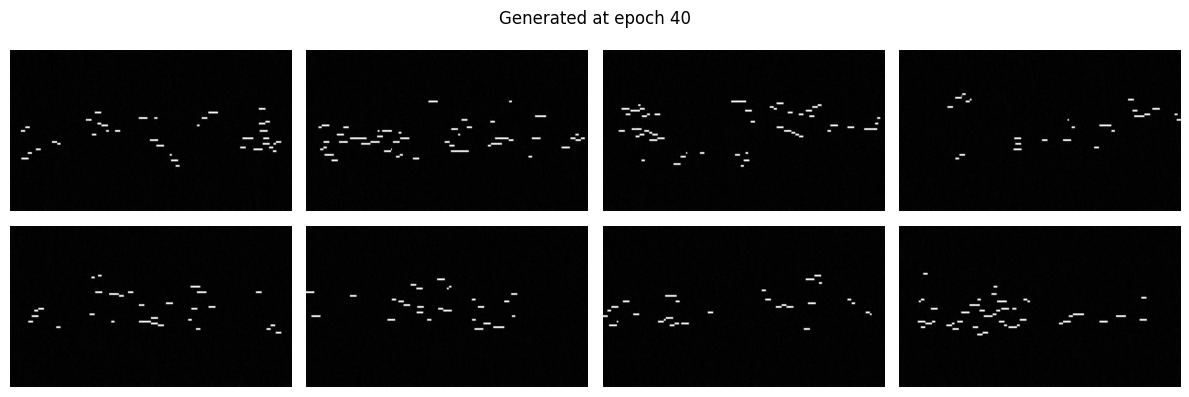

Group 2/5: 100%|██████████| 40/40 [01:47<00:00,  2.70s/it, loss=0.0472]



Epoch 80: Loss = 0.0472


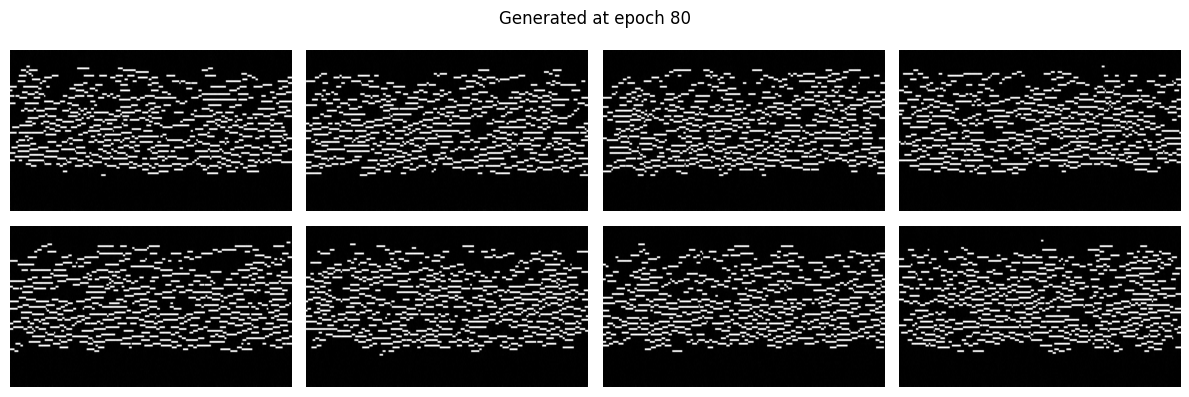

Group 3/5: 100%|██████████| 40/40 [01:45<00:00,  2.64s/it, loss=0.0339]



Epoch 120: Loss = 0.0339


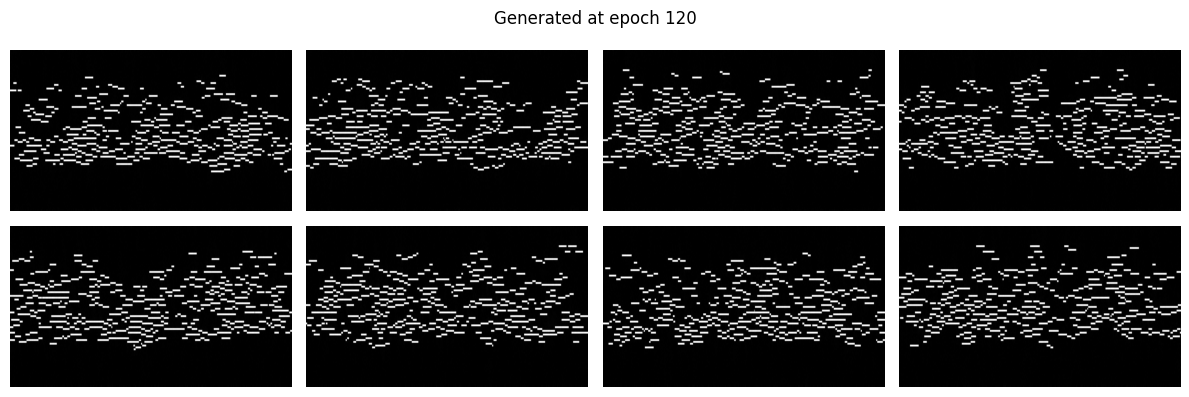

Group 4/5: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it, loss=0.0303]



Epoch 160: Loss = 0.0303


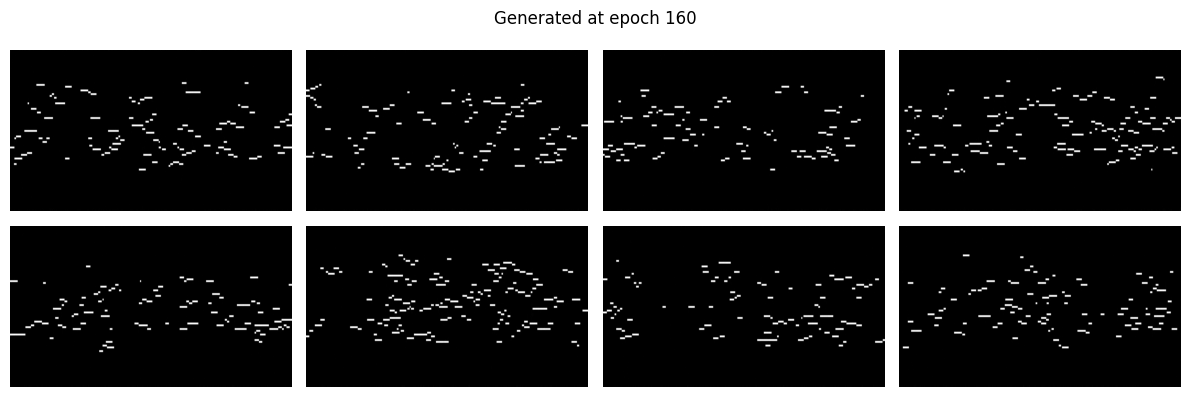

Group 5/5: 100%|██████████| 40/40 [01:47<00:00,  2.69s/it, loss=0.0215]



Epoch 200: Loss = 0.0215


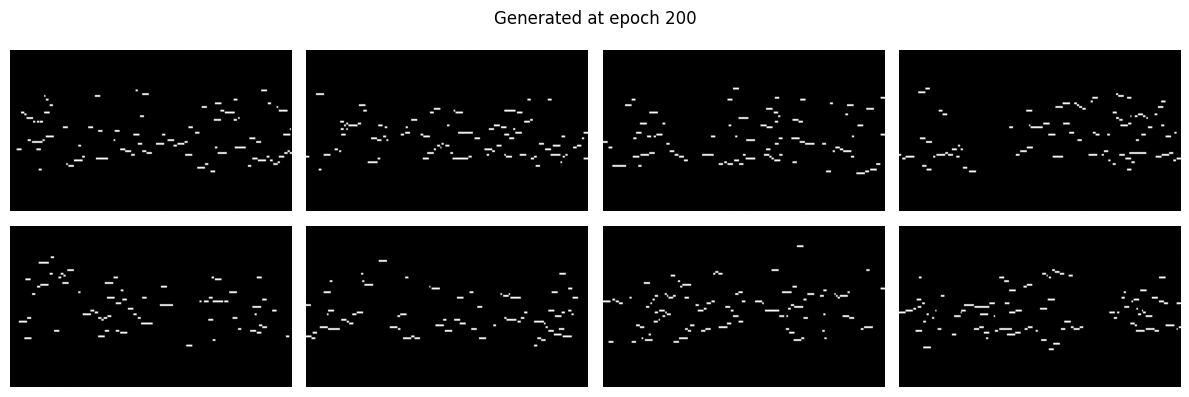


Training complete!


In [81]:
import torch
from models import SimpleUNet, train_diffusion_model

T = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SimpleUNet().to(device)

losses = train_diffusion_model(model, train_loader, T, num_epochs=200, lr=5e-5, gen_freq=20, device=device, img_size=[88,256],
                               save_dir="models/diffusion_checkpoints", save_every=20)


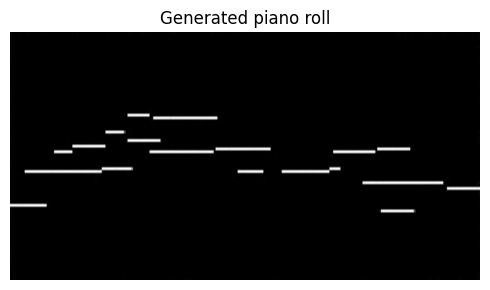

In [83]:
from models import sample_image
from model_helpers import prepare_noise_schedule, show_image_tensor

_, alphas = prepare_noise_schedule(device, timesteps=T)
sample = sample_image(model, alphas, device, img_size=[88,256])
show_image_tensor(sample, title="Generated piano roll")


In [84]:
from midi_conversion import pianoroll_images_to_midi
import numpy as np
from PIL import Image
import os

sample_01 = (sample + 1.0) / 2.0
sample_01 = sample_01.squeeze(0).cpu().numpy()
sample_img = (sample_01 * 255).astype(np.uint8)
img = Image.fromarray(sample_img, mode="L")

output_path = "generated/"
os.makedirs(output_path, exist_ok=True)
img.save(os.path.join(output_path, f"generated_diffusion_sample.png"))

mid = pianoroll_images_to_midi([img], tempo_bpm=120, time_signature=(4, 4))
mid.save("generated/generated_diffusion_sample.mid")


C:\Users\Calvin\AppData\Local\Temp\ipykernel_27696\3470164361.py:9: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(sample_img, mode="L")
